# 最適化入門

ハンズオンにサイドバーGemini（2.5flash）を使いながら進めます。サイドバーGeminiは画面の下側に見える青丸の星形をクリックして使います。  
2.5flashの精度が気に入らない人はサブスク版（ChatGPT-5やGemini2.5Proなど）を使う。（この場合google colabとはコピペ往復になってしまうのが玉にキズ。）

####最適化問題は、しばしば「線形計画問題」の形式で記述できます。
####いったん線形計画問題（の形式）に落とすことができれば、最適化ソルバ(PuLPなど）を利用できます。

### Step 1. 線形計画問題とは
目的関数および制約条件が変数の一次式で表されるもの。

線形計画問題の例（定式化済み）
$$\begin{eqnarray}
&&\max_{x_1,x_2}x_1+2x_2\\
&&\mbox{s.t.}\\
&&\quad x_1+3x_2\le 24\\
&&\quad 4x_1+4x_2\le 48\\
&&\quad 2x_1+x_2\le 22\\
&&\quad x_1\ge 0\\
&&\quad x_2\ge 0
\end{eqnarray}$$

####プロンプト：Step1にて線形計画問題の例を挙げています。PuLPを使ってこの問題を解いてください。

In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 30.4 MB/s eta 0:00:00


In [ ]:
from pulp import *

# 問題を定義
prob = LpProblem("Linear Programming Example", LpMaximize)

# 変数を定義
x1 = LpVariable("x1", 0, None)
x2 = LpVariable("x2", 0, None)

# 目的関数
prob += x1 + 2*x2, "Objective Function"

# 制約条件
prob += x1 + 3*x2 <= 24, "Constraint 1"
prob += 4*x1 + 4*x2 <= 48, "Constraint 2"
prob += 2*x1 + x2 <= 22, "Constraint 3"

# 問題を解く
prob.solve()

# 結果を表示
print("Status:", LpStatus[prob.status])
print("Optimal Solution:")
print("x1 =", value(x1))
print("x2 =", value(x2))
print("Optimal Value =", value(prob.objective))

Status: Optimal
Optimal Solution:
x1 = 6.0
x2 = 6.0
Optimal Value = 18.0


/usr/local/lib/python3.12/dist-packages/pulp/pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


解は得られましたが、実際に制約条件を満足していることを確認します。

####プロンプト：得られた最適解のx_1,x_2が実際に制約条件を満たしていることを確認してください。

In [ ]:
# 最適解
x1_opt = 6.0
x2_opt = 6.0

# 制約条件
constraint1 = x1_opt + 3 * x2_opt
constraint2 = 4 * x1_opt + 4 * x2_opt
constraint3 = 2 * x1_opt + x2_opt

print(f"制約条件1 (x1 + 3*x2 <= 24): {constraint1} <= 24 -> {constraint1 <= 24}")
print(f"制約条件2 (4*x1 + 4*x2 <= 48): {constraint2} <= 48 -> {constraint2 <= 48}")
print(f"制約条件3 (2*x1 + x2 <= 22): {constraint3} <= 22 -> {constraint3 <= 22}")
print(f"制約条件4 (x1 >= 0): {x1_opt} >= 0 -> {x1_opt >= 0}")
print(f"制約条件5 (x2 >= 0): {x2_opt} >= 0 -> {x2_opt >= 0}")

制約条件1 (x1 + 3*x2 <= 24): 24.0 <= 24 -> True
制約条件2 (4*x1 + 4*x2 <= 48): 48.0 <= 48 -> True
制約条件3 (2*x1 + x2 <= 22): 18.0 <= 22 -> True
制約条件4 (x1 >= 0): 6.0 >= 0 -> True
制約条件5 (x2 >= 0): 6.0 >= 0 -> True


### Step 2. MIP（混合整数計画問題）への展開

例題：TSP（巡回セールスマン問題）を解く

地点データ（locations.csv）が与えられている。地点pから出発して、すべての地点（s1,s2,s3,・・・,s9）を通って地点pに戻るときの最短経路（および最短距離）を求めよ。

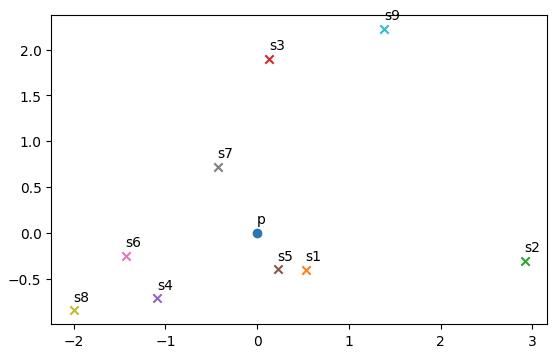

####プロンプト：地点データ(locations.csv)を読み込み、地点pから出発して、すべての地点(s_1,s_2,...,s_9)を通って地点pに戻るときの最短距離および最短経路を求めて下さい。

# Task
"locations.csv" を読み込み、地点 p から出発してすべての地点 (s_1, s_2, ..., s_9) を通り地点 p に戻る最短距離と最短経路を PuLP を用いて求めてください。

## データ読み込み

### Subtask:
locations.csv ファイルを読み込み、地点データを取得します。


**Reasoning**:
The subtask is to load the locations.csv file into a pandas DataFrame. This can be done by importing pandas and using the `read_csv` function.



In [ ]:
import pandas as pd

df_locations = pd.read_csv('/content/locations.csv')
display(df_locations.head())

,k,x,y,depo_flag
0,p,0.000000,0.000000,1
1,s1,0.529473,-0.397044,0
2,s2,2.916925,-0.302511,0
3,s3,0.131532,1.898977,0
4,s4,-1.091079,-0.709964,0


## 距離計算

### Subtask:
各地点間の距離を計算するための関数を定義します。


**Reasoning**:
Define a function to calculate the Euclidean distance between two points using numpy.



In [ ]:
import numpy as np

def distance(x1, y1, x2, y2):
  """Calculates the Euclidean distance between two points."""
  return np.sqrt(np.square(x1 - x2) + np.square(y1 - y2))

## Tsp定式化

### Subtask:
PuLP を使用して、巡回セールスマン問題を混合整数計画問題として定式化します。これには、目的関数（総移動距離の最小化）と制約条件（各地点に一度だけ訪問し、出発地点に戻る）を含めます。


**Reasoning**:
Define the TSP problem as a mixed integer program using PuLP, including binary decision variables for travel between points, the objective function to minimize total distance, and constraints for entering and leaving each node once, along with MTZ constraints to eliminate subtours.



In [ ]:
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, value

# 地点データを準備
locations = df_locations[['x', 'y']].values
n = len(locations)
location_indices = range(n)

# 距離行列を計算
distances = np.zeros((n, n))
for i in location_indices:
    for j in location_indices:
        if i != j:
            distances[i, j] = distance(locations[i, 0], locations[i, 1], locations[j, 0], locations[j, 1])

# 問題を定義
prob = LpProblem("TSP", LpMinimize)

# 変数を定義: x[i][j] は地点iから地点jへの移動があるかどうかの二値変数
x = LpVariable.dicts("x", (location_indices, location_indices), 0, 1, cat='Binary')

# 変数を定義: u[i] は地点iの訪問順序 (MTZ定式化用)
u = LpVariable.dicts("u", location_indices, 0, n - 1)

# 目的関数: 総移動距離の最小化
prob += lpSum(distances[i][j] * x[i][j] for i in location_indices for j in location_indices if i != j), "Total Distance"

# 制約条件

# 1. 各地点には一度だけ入る (出発地点以外)
for j in location_indices:
    if j != 0: # 出発地点 (インデックス0) 以外
        prob += lpSum(x[i][j] for i in location_indices if i != j) == 1, f"Enter_{j}"

# 2. 各地点からは一度だけ出る (出発地点以外)
for i in location_indices:
    if i != 0: # 出発地点 (インデックス0) 以外
        prob += lpSum(x[i][j] for j in location_indices if i != j) == 1, f"Leave_{i}"

# 3. 出発地点からは一度だけ出る
prob += lpSum(x[0][j] for j in location_indices if j != 0) == 1, "Leave_Depot"

# 4. 出発地点には一度だけ入る
prob += lpSum(x[i][0] for i in location_indices if i != 0) == 1, "Enter_Depot"

# 5. 部分巡回路を排除 (MTZ定式化)
# M は十分に大きな値 (ここでは地点数 n を使用)
M = n
for i in location_indices:
    for j in location_indices:
        if i != j and i != 0 and j != 0: # 出発地点 0 を除く
            prob += u[i] - u[j] + M * x[i][j] <= M - 1, f"MTZ_{i}_{j}"

# 問題を表示 (定式化の確認)
print(prob)

TSP:
MINIMIZE
0.661804898546483*x_0_1 + 2.932569959569394*x_0_2 + 1.903527135779046*x_0_3 + 1.3017303874107433*x_0_4 + 0.4553824651008621*x_0_5 + 1.4522785543897057*x_0_6 + 0.8425129739306184*x_0_7 + 2.1672450270010013*x_0_8 + 2.6223170683761907*x_0_9 + 0.661804898546483*x_1_0 + 2.389323285064537*x_1_2 + 2.33025149097131*x_1_3 + 1.6504869491807492*x_1_4 + 0.3043514798712115*x_1_5 + 1.966610940851162*x_1_6 + 1.476090149252683*x_1_7 + 2.565781990068833*x_1_8 + 2.760666843346126*x_1_9 + 2.932569959569394*x_2_0 + 2.389323285064537*x_2_1 + 3.5503473835679253*x_2_3 + 4.028661918273781*x_2_4 + 2.6934191514343584*x_2_5 + 4.348612082765562*x_2_6 + 3.501421970979585*x_2_7 + 4.943998728414635*x_2_8 + 2.9604949986001756*x_2_9 + 1.903527135779046*x_3_0 + 2.33025149097131*x_3_1 + 3.5503473835679253*x_3_2 + 2.881206652884047*x_3_4 + 2.2967290275659575*x_3_5 + 2.65382557280395*x_3_6 + 1.3023701932891987*x_3_7 + 3.469437825388361*x_3_8 + 1.2929132484695318*x_3_9 + 1.3017303874107433*x_4_0 + 1.650486949

## 問題解決

### Subtask:
定式化された混合整数計画問題をソルバで解きます。


**Reasoning**:
Use the solve method to solve the defined optimization problem and print the status of the solution.



In [ ]:
# 問題を解く
prob.solve()

# 結果を表示
print("Status:", LpStatus[prob.status])

Status: Optimal


**Reasoning**:
Print the optimal value of the objective function and the values of the decision variables to see the shortest distance and the chosen path.



In [ ]:
print("Optimal Value =", value(prob.objective))

# 最適経路の表示
print("\nOptimal Route:")
start_node = 0 # 地点 p のインデックス
current_node = start_node
route = [df_locations.iloc[start_node]['k']]

while True:
    next_node = -1
    for j in location_indices:
        if current_node != j and value(x[current_node][j]) == 1.0:
            next_node = j
            break
    if next_node != -1:
        route.append(df_locations.iloc[next_node]['k'])
        current_node = next_node
        if current_node == start_node:
            break
    else:
        # Should not happen in a valid TSP solution
        print("Error: Could not find the next node.")
        break

print(" -> ".join(route))

Optimal Value = 13.137275945115999

Optimal Route:
p -> s5 -> s1 -> s2 -> s9 -> s3 -> s7 -> s6 -> s8 -> s4 -> p


## 結果抽出

### Subtask:
得られた最適解から、最短距離と最短経路を抽出します。


**Reasoning**:
Extract the optimal objective value and the optimal route from the solved PuLP problem and store them in variables.



In [ ]:
# 最短距離を取得
shortest_distance = value(prob.objective)

# 最短経路を抽出
shortest_route = []
start_node = 0  # 地点 p のインデックス

# 地点インデックスと地点名のマッピング
index_to_location_name = df_locations.set_index(df_locations.index)['k'].to_dict()

current_node = start_node
shortest_route.append(index_to_location_name[current_node])

# 経路をたどる
while True:
    next_node = -1
    for j in location_indices:
        if current_node != j and value(x[current_node][j]) == 1.0:
            next_node = j
            break

    if next_node != -1:
        shortest_route.append(index_to_location_name[next_node])
        current_node = next_node
        if current_node == start_node:
            break
    else:
        # Should not happen in a valid TSP solution
        print("Error: Could not find the next node.")
        break

# 結果を表示
print(f"Shortest Distance: {shortest_distance}")
print(f"Shortest Route: {' -> '.join(shortest_route)}")

Shortest Distance: 13.137275945115999
Shortest Route: p -> s5 -> s1 -> s2 -> s9 -> s3 -> s7 -> s6 -> s8 -> s4 -> p


## 結果表示

### Subtask:
最短距離と最短経路を表示します。


**Reasoning**:
Display the shortest distance and the shortest route as requested in the instructions.



In [ ]:
# 最短距離を表示
print(f"Shortest Distance: {shortest_distance}")

# 最短経路を表示
print(f"Shortest Route: {' -> '.join(shortest_route)}")

Shortest Distance: 13.137275945115999
Shortest Route: p -> s5 -> s1 -> s2 -> s9 -> s3 -> s7 -> s6 -> s8 -> s4 -> p


## Summary:

### Q&A
*   地点 p から出発してすべての地点 (s_1, s_2, ..., s_9) を通り地点 p に戻る最短距離はいくつですか？
    最短距離は約 13.14 です。
*   地点 p から出発してすべての地点 (s_1, s_2, ..., s_9) を通り地点 p に戻る最短経路は何ですか？
    最短経路は p -> s5 -> s1 -> s2 -> s9 -> s3 -> s7 -> s6 -> s8 -> s4 -> p です。

### Data Analysis Key Findings
*   `locations.csv` ファイルが正常に読み込まれました。
*   各地点間のユークリッド距離を計算する関数が定義されました。
*   巡回セールスマン問題が PuLP を用いて混合整数計画問題として定式化されました。これには、総移動距離の最小化を目的関数とし、各地点に一度だけ訪問し出発地点に戻るという制約、および部分巡回路を排除するための MTZ 定式化が含まれます。
*   定式化された問題が PuLP で解かれ、解の状態は "Optimal" でした。
*   計算された最短距離は 13.137275945115999 でした。
*   抽出された最短経路は p -> s5 -> s1 -> s2 -> s9 -> s3 -> s7 -> s6 -> s8 -> s4 -> p でした。

### Insights or Next Steps
*   このモデルは、より多くの地点や追加の制約（例: 時間枠、容量）を含む、より複雑な配送ルート最適化問題にも拡張できます。
*   異なるソルバー（例: Gurobi, CPLEX）を使用することで、大規模な問題に対する計算パフォーマンスを比較検討できます。


####プロンプト：Data Analysis Key Findings内に「巡回セールスマン問題が PuLP を用いて混合整数計画問題として定式化されました。」とあります。どのように混合整数計画問題として定式化したのか線形計画問題の知識しかない初心者に対してもわかりやすく説明してください。

####プロンプト：得られた解が制約条件を満足していることを確認してください。

In [ ]:
# 得られた最適解が制約条件を満足しているか確認

print("Checking Constraints:")
for name, constraint in prob.constraints.items():
    # PuLPの制約オブジェクトの式を取得し、value() で評価する
    constraint_value = value(constraint.expr)

    # 制約のタイプ (<=, >=, =) を確認して評価
    if constraint.sense == LpConstraintLE: # <=
        # 左辺の値 <= 右辺の値 + 許容誤差
        is_satisfied = constraint_value <= constraint.constant + 1e-6 # 浮動小数点誤差を考慮
        print(f"  {name}: {constraint_value} <= {constraint.constant} -> {is_satisfied}")
    elif constraint.sense == LpConstraintGE: # >=
        # 左辺の値 >= 右辺の値 - 許容誤差
        is_satisfied = constraint_value >= constraint.constant - 1e-6 # 浮動小数点誤差を考慮
        print(f"  {name}: {constraint_value} >= {constraint.constant} -> {is_satisfied}")
    elif constraint.sense == LpConstraintEQ: # =
         # 左辺の値と右辺の値の差が許容誤差の範囲内
         is_satisfied = abs(constraint_value - constraint.constant) < 1e-6 # 浮動小数点誤差を考慮
         print(f"  {name}: {constraint_value} == {constraint.constant} -> {is_satisfied}")
    else:
        print(f"  {name}: Unknown constraint type.")

# 変数の範囲制約 (0-1, 0 <= u <= n-1) は PuLP が自動で処理するため、ここでは省略します。
# MTZ 制約は u の値と x の値から間接的に確認できますが、ここでは主要なフロー制約を中心に確認します。

Checking Constraints:
  Enter_1: 1.0 == -1.0 -> False
  Enter_2: 1.0 == -1.0 -> False
  Enter_3: 1.0 == -1.0 -> False
  Enter_4: 1.0 == -1.0 -> False
  Enter_5: 1.0 == -1.0 -> False
  Enter_6: 1.0 == -1.0 -> False
  Enter_7: 1.0 == -1.0 -> False
  Enter_8: 1.0 == -1.0 -> False
  Enter_9: 1.0 == -1.0 -> False
  Leave_1: 1.0 == -1.0 -> False
  Leave_2: 1.0 == -1.0 -> False
  Leave_3: 1.0 == -1.0 -> False
  Leave_4: 1.0 == -1.0 -> False
  Leave_5: 1.0 == -1.0 -> False
  Leave_6: 1.0 == -1.0 -> False
  Leave_7: 1.0 == -1.0 -> False
  Leave_8: 1.0 == -1.0 -> False
  Leave_9: 1.0 == -1.0 -> False
  Leave_Depot: 1.0 == -1.0 -> False
  Enter_Depot: 1.0 == -1.0 -> False
  MTZ_1_2: 9.0 <= -9 -> False
  MTZ_1_3: -3.0 <= -9 -> False
  MTZ_1_4: -8.0 <= -9 -> False
  MTZ_1_5: 1.0 <= -9 -> False
  MTZ_1_6: -6.0 <= -9 -> False
  MTZ_1_7: -5.0 <= -9 -> False
  MTZ_1_8: -7.0 <= -9 -> False
  MTZ_1_9: -2.0 <= -9 -> False
  MTZ_2_1: 1.0 <= -9 -> False
  MTZ_2_3: -2.0 <= -9 -> False
  MTZ_2_4: -7.0 <= -9 -